<a href="https://colab.research.google.com/github/amelierueeck/ULM-25-authorship-profiling/blob/main/src/BERT_probing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT Layer Probing for Authorship Profiling

This notebook implements **layer-wise probing** of pre-trained BERT models to investigate how demographic information (age and gender) is encoded across different layers. The analysis compares probe performance between pre-trained and fine-tuned models to understand how fine-tuning affects the representation of demographic features.

## Methodology
1. **Extract activations**: Get [CLS] token representations from each BERT layer (0-12)
2. **Train probes**: Use logistic regression to predict age/gender from layer activations
3. **Compare models**: Analyze differences between pre-trained and fine-tuned BERT representations
4. **Visualize results**: Plot probe accuracy across layers to identify where demographic information is encoded

## Key Research Questions
- Which BERT layers encode age vs. gender information?
- How does fine-tuning change the distribution of demographic features across layers?
- Are there layer-specific patterns for different demographic attributes?

In [ ]:
# Core libraries for BERT model loading and tensor operations
import torch
from transformers import BertTokenizer, BertModel
from transformers import AutoTokenizer, AutoModel

# Data manipulation and analysis
import numpy as np
import pandas as pd
import sys
import os

# Machine learning components for probing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [ ]:
# Load pre-split datasets for consistent evaluation across experiments
# These splits ensure no data leakage and enable reproducible results

# Load training data for probe training
train_df = pd.read_csv("../data/data_train.csv")
# Load validation data for model selection and hyperparameter tuning
val_df   = pd.read_csv("../data/data_val.csv")
# Load test data for final evaluation
test_df  = pd.read_csv("../data/data_test.csv")

print(train_df.head())

In [ ]:
# Display dataset sizes to verify data loading and understand experimental scale
print(f"Train instances: {train_df.shape[0]}")
print(f"Val instances: {val_df.shape[0]}")
print(f"Test instances: {test_df.shape[0]}")

In [ ]:
# Initialize pre-trained BERT model for layer-wise probing analysis
# Using bert-base-cased to preserve case information which may be relevant for authorship profiling

model_name = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
# Enable output_hidden_states=True to access all layer representations
model = AutoModel.from_pretrained(model_name, output_hidden_states=True).to("cuda")
# Set to evaluation mode to disable dropout and ensure consistent representations
model.eval()

In [ ]:
def get_activations(batch, layer=0, batch_size=64, max_len=256):
    """
    Extract hidden state activations from a specific BERT layer for a batch of texts.
    
    This function processes text inputs through BERT and extracts the [CLS] token 
    representation from the specified layer, which serves as a sentence-level 
    representation for downstream probing tasks.
    
    Args:
        batch (list): List of text strings to process
        layer (int): BERT layer index to extract activations from (0-12 for base models)
                    Layer 0 = embeddings, Layers 1-12 = transformer layers
        batch_size (int): Number of texts to process simultaneously (unused in current implementation)
        max_len (int): Maximum sequence length for tokenization (longer sequences are truncated)
    
    Returns:
        torch.Tensor: Tensor of shape [batch_size, hidden_size] containing [CLS] token 
                     representations from the specified layer, or None if processing fails
    
    Note:
        - Uses [CLS] token (index 0) as the sentence-level representation
        - Applies truncation and padding for consistent input lengths
        - Handles GPU memory efficiently with torch.no_grad()
    """
    activations = []
    try:
        # Tokenize the batch with consistent preprocessing
        inputs = tokenizer(batch, return_tensors="pt", truncation=True,
                    padding=True, max_length=max_len).to("cuda")
    except TypeError:
        return None
    
    # Extract activations without gradient computation to save memory
    with torch.no_grad():
        outputs = model(**inputs)
        # hidden_states is a tuple of 13 tensors: [batch_size, seq_len, hidden_size]
        hidden_states = outputs.hidden_states  

    # Extract [CLS] token (index 0) from the specified layer as sentence representation
    return hidden_states[layer][:,0,:]

In [ ]:
def train_probe(X_train, y_train, X_val, y_val):
    """
    Train a logistic regression probe to predict demographic labels from BERT activations.
    
    This function implements the core probing methodology by training a linear classifier
    on BERT layer representations to test what demographic information is encoded
    in those representations.
    
    Args:
        X_train (np.ndarray): Training features (BERT activations) of shape [n_samples, hidden_size]
        y_train (np.ndarray): Training labels (age or gender) of shape [n_samples]
        X_val (np.ndarray): Validation features for evaluation
        y_val (np.ndarray): Validation labels for evaluation
    
    Returns:
        tuple: (accuracy_score, trained_classifier)
            - accuracy_score (float): Classification accuracy on validation set
            - trained_classifier: Fitted LogisticRegression model
    
    Note:
        - Uses multinomial logistic regression for multi-class age prediction
        - SAGA solver handles both binary and multi-class scenarios efficiently
        - L2 regularization prevents overfitting on high-dimensional BERT features
    """
    # Configure logistic regression for robust probing
    clf = LogisticRegression(
        solver="saga",          # Efficient for large datasets and multinomial classification
        multi_class="multinomial",  # Proper multi-class handling for age groups
        penalty="l2",           # L2 regularization to prevent overfitting
        max_iter=500,          # Sufficient iterations for convergence
        n_jobs=-1              # Parallel processing for faster training
    )
    
    # Train the probe on BERT activations
    clf.fit(X_train, y_train)
    
    # Evaluate probe performance on validation set
    y_pred = clf.predict(X_val)
    return accuracy_score(y_val, y_pred), clf

In [ ]:
# Prepare gender labels for binary classification task
# Extract gender labels from datasets for probe training
y_train_gender = train_df["gender"].to_list()
y_val_gender   = val_df["gender"].to_list()
y_test_gender  = test_df["gender"].to_list()

In [ ]:
# Convert categorical gender labels to numerical format for sklearn compatibility
from sklearn.preprocessing import LabelEncoder

# Initialize label encoder and fit on all available labels to ensure consistency
label_encoder = LabelEncoder()
# Fit on combined train and test sets to handle all possible label values
label_encoder.fit(y_train_gender + y_test_gender)  
# Transform gender labels to numerical values (e.g., 'male'->0, 'female'->1)
y_train_gender = label_encoder.transform(y_train_gender)
y_test_gender = label_encoder.transform(y_test_gender)

In [ ]:
# Prepare age labels for multi-class classification task
# Age groups are pre-defined discrete categories (e.g., 13-17, 18-22, etc.)
y_train_age = train_df["age"].values
y_val_age   = val_df["age"].values
y_test_age  = test_df["age"].values

In [ ]:
# Import progress tracking for long-running batch processing
from tqdm import tqdm

def _get_batch(x_data, y_data, batch_size, layer_idx):
    """
    Extract BERT activations for a specific layer from a dataset in batches.
    
    This helper function processes text data in batches to manage GPU memory efficiently
    while extracting hidden state representations from a specified BERT layer.
    
    Args:
        x_data (list): List of text strings to process
        y_data (list): Corresponding labels for the texts
        batch_size (int): Number of texts to process per batch
        layer_idx (int): BERT layer index to extract activations from (0-12)
    
    Returns:
        tuple: (activations_tensor, labels_tensor)
            - activations_tensor: Concatenated [CLS] token representations from all batches
            - labels_tensor: Corresponding labels as PyTorch tensor
    
    Note:
        - Processes data in batches to prevent GPU memory overflow
        - Moves activations to CPU immediately to free GPU memory
        - Uses tqdm for progress tracking during long extractions
    """
    acts = []
    labels = []
    
    # Process dataset in batches with progress tracking
    for i in tqdm(range(0, len(x_data), batch_size)):
        batch_x = x_data[i:i+batch_size]
        batch_y = y_data[i:i+batch_size]

        # Extract activations for current batch and specified layer
        batch_acts = get_activations(batch_x, layer=layer_idx, batch_size=batch_size)
        if batch_acts is not None:
            # Move to CPU immediately to free GPU memory for next batch
            acts.append(batch_acts.cpu())
            labels.append(torch.tensor(batch_y, dtype=torch.long))

    # Concatenate all batch results into single tensors
    return torch.cat(acts, dim=0), torch.cat(labels, dim=0)


def run_probe(x_train, y_train, x_test, y_test, batch_size=64, num_layers=13):
    """
    Conduct comprehensive layer-wise probing analysis across all BERT layers.
    
    This function implements the core experimental pipeline by extracting activations
    from each BERT layer and training probes to evaluate how well demographic
    information can be predicted from each layer's representations.
    
    Args:
        x_train (list): Training text data
        y_train (list): Training labels (age or gender)
        x_test (list): Test text data for evaluation
        y_test (list): Test labels for evaluation
        batch_size (int): Batch size for activation extraction (default: 64)
        num_layers (int): Number of BERT layers to probe (default: 13 for base model)
    
    Returns:
        list: Probe accuracy scores for each layer [layer_0_acc, layer_1_acc, ..., layer_12_acc]
    
    Note:
        - Processes each layer sequentially to manage memory efficiently
        - Clears GPU cache between layers to prevent out-of-memory errors
        - Returns accuracy scores that can be plotted to visualize layer-wise performance
    """
    results = []
    
    # Iterate through all BERT layers (embeddings + 12 transformer layers)
    for layer_idx in range(num_layers):
        print("Layer:", layer_idx)
        try:
            # Extract activations for current layer
            train_acts, train_labels = _get_batch(x_train, y_train, batch_size, layer_idx)
            test_acts, test_labels = _get_batch(x_test, y_test, batch_size, layer_idx)
        except TypeError as e:
            print(e)
            continue
            
        # Convert PyTorch tensors to NumPy arrays for sklearn compatibility
        X_train = train_acts.numpy()
        y_train_np = train_labels.numpy()
        X_test = test_acts.numpy()
        y_test_np = test_labels.numpy()

        # Train probe and evaluate on test set
        acc, _ = train_probe(X_train, y_train_np, X_test, y_test_np)
        results.append(acc)

        print(f"Layer {layer_idx}: Accuracy = {acc:.4f}")

        # Free memory between layers to prevent accumulation
        del train_acts, train_labels, test_acts, test_labels
        torch.cuda.empty_cache()

    return results

In [ ]:
# Run comprehensive age probing analysis across all BERT layers
# This experiment tests how well age information can be decoded from each layer's representations

# Prepare datasets for age probing
x_train = train_df["text"].to_list()
x_test = test_df["text"].to_list()
num_layers = 13  # BERT-base has 13 layers (embeddings + 12 transformer layers)

# Execute layer-wise probing for age prediction
print("Starting age probing analysis...")
results_age = run_probe(x_train, y_train_age, x_test, y_test_age, batch_size=64, num_layers=num_layers)

In [ ]:
# Run comprehensive gender probing analysis across all BERT layers  
# This experiment tests how well gender information can be decoded from each layer's representations

print("Starting gender probing analysis...")
results_gender = run_probe(x_train, y_train_gender, x_test, y_test_gender, batch_size=64, num_layers=num_layers)

In [31]:
results_gender = run_probe(x_train, y_train_gender, x_test, y_test_gender, batch_size=64, num_layers=num_layers)

Layer: 0


100%|██████████| 593/593 [01:10<00:00,  8.37it/s]
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1262: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Layer 0: Accuracy = 0.5374
Layer: 1


100%|██████████| 593/593 [01:10<00:00,  8.42it/s]
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1262: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


Layer 1: Accuracy = 0.6778
Layer: 2


100%|██████████| 593/593 [01:10<00:00,  8.41it/s]
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1262: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


Layer 2: Accuracy = 0.6855
Layer: 3


100%|██████████| 9701/9701 [19:40<00:00,  8.22it/s]
IOPub message rate exceeded.:38<00:34,  7.97it/s]
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|██████████| 593/593 [01:10<00:00,  8.36it/s]
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1262: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Layer 3: Accuracy = 0.6683
Layer: 4


100%|██████████| 593/593 [01:10<00:00,  8.40it/s]
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1262: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


Layer 4: Accuracy = 0.6025
Layer: 5


100%|██████████| 593/593 [01:10<00:00,  8.39it/s]
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1262: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


Layer 5: Accuracy = 0.5674
Layer: 6


100%|██████████| 593/593 [01:10<00:00,  8.37it/s]
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1262: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


Layer 6: Accuracy = 0.6850
Layer: 7


100%|██████████| 593/593 [01:10<00:00,  8.38it/s]
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1262: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


Layer 7: Accuracy = 0.6529
Layer: 8


100%|██████████| 593/593 [01:11<00:00,  8.32it/s]
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1262: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


Layer 8: Accuracy = 0.6813
Layer: 9


100%|██████████| 593/593 [01:10<00:00,  8.39it/s]
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1262: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


Layer 9: Accuracy = 0.6785
Layer: 10


100%|██████████| 593/593 [01:10<00:00,  8.40it/s]
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1262: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


Layer 10: Accuracy = 0.6777
Layer: 11


100%|██████████| 9701/9701 [19:45<00:00,  8.18it/s]
IOPub message rate exceeded.:21<00:49,  8.34it/s]
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Layer 12: Accuracy = 0.6852


In [ ]:
# Visualize layer-wise probing results to identify optimal layers for demographic prediction
import matplotlib.pyplot as plt

# Create comprehensive comparison plot showing both age and gender probe performance
plt.figure(figsize=(10, 6))
plt.plot(range(num_layers), results_gender, marker="o", label="Gender", linewidth=2, markersize=6)
plt.plot(range(num_layers), results_age, marker="s", label="Age", linewidth=2, markersize=6)

# Enhance plot readability and interpretation
plt.xlabel("Layer Index")
plt.ylabel("Probe Accuracy")
plt.title("Layer-wise Probing Performance: Pre-trained BERT")
plt.legend()
plt.grid(True, alpha=0.3)  # Add subtle grid for easier reading
plt.xticks(range(num_layers))  # Show all layer indices

# Save results for comparison with fine-tuned model
plt.savefig("../results/bert_pretrained_probes.png", dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics for analysis
print(f"Gender - Best layer: {np.argmax(results_gender)} (accuracy: {max(results_gender):.4f})")
print(f"Age - Best layer: {np.argmax(results_age)} (accuracy: {max(results_age):.4f})")

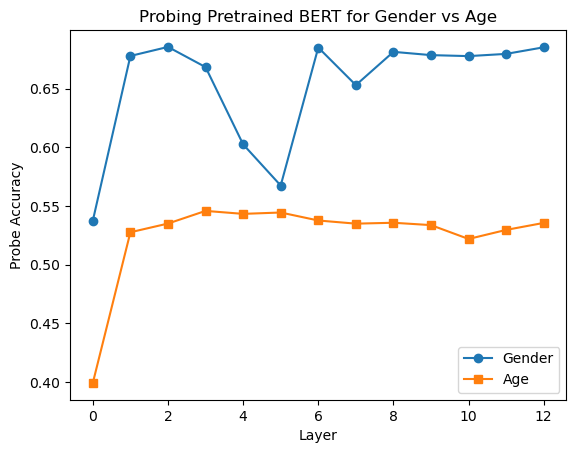

In [35]:
import matplotlib.pyplot as plt

plt.plot(range(num_layers), results_gender, marker="o", label="Gender")
plt.plot(range(num_layers), results_age, marker="s", label="Age")
plt.xlabel("Layer")
plt.ylabel("Probe Accuracy")
plt.title("Probing Pretrained BERT for Gender vs Age")
plt.legend()
plt.savefig("../results/bert_pretrained_probes.png")
plt.show()